In [1]:
from fastai.utils.collect_env import *
from fastai.vision import *

In [2]:
show_install()



```text
=== Software === 
python        : 3.6.4
fastai        : 1.0.52
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 418.40
torch cuda    : 9.0.176 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16130MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-4.14.63-coreos-x86_64-with-debian-stretch-sid
distro        : #1 SMP Wed Aug 15 22:26:16 UTC 2018
conda env     : Unknown
python        : /opt/conda/envs/pytorch-py3.6/bin/python
sys.path      : 
/home/code-base/runtime/app
/home/code-base/runtime/app/python
/home/code-base/runtime/app/python/sensei_sdk
/home/code-base/runtime/app/python/dev
/home/code-base/app/python
/home/code-base/app/python/sensei_sdk
/home/code-base/app/python/senseinbs
/home/code-base/app/plugins
/home/code-base/app/plugins/jupyterlab-zip
/home/code-base/runtime/notebooks/experimental
/opt/conda/envs/pytorch-py3.6/lib/python36.zip
/opt/conda/envs/pytorch-py3.6

In [3]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [4]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .split_by_rand_pct()
        .label_from_df(label_delim=' ')
        .transform(planet_tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

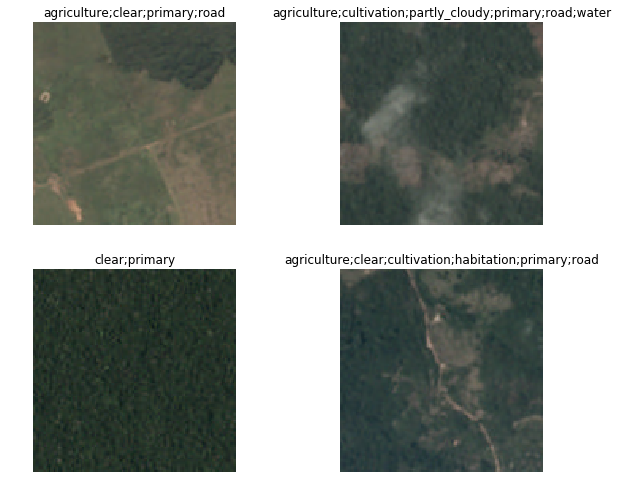

In [5]:
data.show_batch(rows=2, figsize=(9,7))

In [22]:
class MultiLabelFbeta(LearnerCallback):
    "Computes the fbeta score for multilabel classification"
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    _order = -20 
    def __init__(self, learn, beta, eps, thresh, sigmoid, average):
        super().__init__(learn)
        self.eps=eps
        self.thresh=thresh
        self.sigmoid=sigmoid
        self.average=average
        self.beta2=beta**2

    def on_train_begin(self, **kwargs):
        self.c = self.learn.data.c
        if self.average != "none": self.learn.recorder.add_metric_names([f'{self.average}_fbeta'])
        else: self.learn.recorder.add_metric_names([f"fbeta_{c}" for c in self.learn.data.classes])

    def on_epoch_begin(self, **kwargs):
        dvc = self.learn.data.device
        self.tp = torch.zeros(self.c).to(dvc)
        self.total_pred = torch.zeros(self.c).to(dvc)
        self.total_targ = torch.zeros(self.c).to(dvc)
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        pred, targ = (last_output.sigmoid() if self.sigmoid else last_output) > self.thresh, last_target.byte()
        m = pred*targ
        self.tp += m.sum(0).float()
        self.total_pred += pred.sum(0).float()
        self.total_targ += targ.sum(0).float()
    
    def fbeta_score(self, precision, recall):
        return (1 + self.beta2)*(precision*recall)/((self.beta2*precision + recall) + self.eps)

    def on_epoch_end(self, last_metrics, **kwargs):
        self.total_pred += self.eps
        self.total_targ += self.eps # train, validation mismatch causing
        if self.average == "micro":
            precision, recall = self.tp.sum() / self.total_pred.sum(), self.tp.sum() / self.total_targ.sum()
            res = self.fbeta_score(precision, recall)
        
        elif self.average == "macro":
            res = self.fbeta_score((self.tp / self.total_pred), (self.tp / self.total_targ)).mean()
        
        elif self.average == "weighted":
            scores = self.fbeta_score((self.tp / self.total_pred), (self.tp / self.total_targ))
            res = (scores*self.total_targ).sum() / self.total_targ.sum()
        
        elif self.average == "none":
            res = listify(self.fbeta_score((self.tp / self.total_pred), (self.tp / self.total_targ)))
        
        else:
            raise Exception("Choose one of the average types: [micro, macro, weighted, none]")
        
        return add_metrics(last_metrics, res)

In [23]:
learn = cnn_learner(data, models.resnet18,
                    callback_fns=[partial(MultiLabelFbeta, beta=2, eps=1e-8, 
                                          thresh=0.3, sigmoid=True, average="micro")])
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,micro_fbeta,time
0,0.803684,0.732491,0.526786,00:00


In [24]:
learn = cnn_learner(data, models.resnet18,
                    callback_fns=[partial(MultiLabelFbeta, beta=2, eps=1e-8, 
                                          thresh=0.3, sigmoid=True, average="macro")])
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,macro_fbeta,time
0,0.839635,0.711979,0.368583,00:00


In [26]:
learn = cnn_learner(data, models.resnet18,
                    callback_fns=[partial(MultiLabelFbeta, beta=2, eps=1e-8, 
                                          thresh=0.3, sigmoid=True, average="weighted")])
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,weighted_fbeta,time
0,0.836107,0.845309,0.662963,00:00


In [21]:
learn = cnn_learner(data, models.resnet18,
                    callback_fns=[partial(MultiLabelFbeta, beta=2, eps=1e-8, 
                                          thresh=0.3, sigmoid=True, average="none")])
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,fbeta_agriculture,fbeta_artisinal_mine,fbeta_bare_ground,fbeta_blooming,fbeta_clear,fbeta_cloudy,fbeta_cultivation,fbeta_habitation,fbeta_haze,fbeta_partly_cloudy,fbeta_primary,fbeta_road,fbeta_selective_logging,fbeta_water,time
0,0.835275,0.803319,0.623188,0.097403,0.129032,0.092593,0.789037,0.149701,0.401786,0.333333,0.229885,0.482143,0.846253,0.477032,0.069444,0.330578,00:00


### Test with Scikit

In [53]:
from sklearn.metrics import f1_score
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]

In [57]:
print(f1_score(y_true, y_pred, average='macro'))
print(f1_score(y_true, y_pred, average='micro'))
print(f1_score(y_true, y_pred, average='weighted'))
print(f1_score(y_true, y_pred, average=None))

0.26666666666666666
0.3333333333333333
0.26666666666666666
[0.8 0.  0. ]


In [99]:
y_true = torch.tensor([0, 1, 2, 0, 1, 2])
y_pred = torch.tensor([0, 2, 1, 0, 0, 1])

In [118]:
a = torch.zeros(len(y_true), 3)
a[range(y_true.shape[0]), y_true] = 1
b = torch.zeros(len(y_pred), 3)
b[range(y_pred.shape[0]), y_pred] = 1

In [123]:
pred, targ = b, a

In [145]:
m = pred*targ
tp = m.sum(0).float()
total_pred = pred.sum(0).float()
total_targ = targ.sum(0).float()

In [167]:
def fbeta_score(precision, recall):
    return (1 + 1)*(precision*recall)/((1*precision + recall) + 1e-15)

In [168]:
eps = 1e-15

In [169]:
tp, total_pred, total_targ

(tensor([2., 0., 0.]), tensor([3., 2., 1.]), tensor([2., 2., 2.]))

In [170]:
tp / total_pred, tp / total_targ

(tensor([0.6667, 0.0000, 0.0000]), tensor([1., 0., 0.]))

In [171]:
total_pred += eps

In [172]:
precision, recall = tp.sum() / total_pred.sum(), tp.sum() / total_targ.sum()
res = fbeta_score(precision, recall)
print(res)

tensor(0.3333)


In [173]:
res = fbeta_score((tp / total_pred), (tp / total_targ)).mean()
print(res)

tensor(0.2667)


In [174]:
scores = fbeta_score((tp / total_pred), (tp / total_targ))
res = (scores*total_targ).sum() / total_targ.sum()
print(res)

tensor(0.2667)


In [175]:
res = listify(fbeta_score((tp / total_pred), (tp / total_targ)))
print(res)

[tensor(0.8000), tensor(0.), tensor(0.)]


In [176]:
total_targ, total_pred

(tensor([2., 2., 2.]), tensor([3., 2., 1.]))